# FINAL HOMEWORK - Francesca Zorzi
## 1 — Introduction
The result of mod(YOUR_STUDENT_ID_NUMBER, 3) + 1 is:


In [1]:
(2157563 % 3) + 1

3

## 2 — Setup definition


In [2]:
import os
import ctypes
acados_path = "/Users/francescazorzi/acados"
os.environ["ACADOS_SOURCE_DIR"] = acados_path
os.environ["DYLD_LIBRARY_PATH"] = f"{acados_path}/lib"
ctypes.CDLL(f"{acados_path}/lib/libblasfeo.dylib", mode=ctypes.RTLD_GLOBAL)
# Carica libhpipm (quella che ti dava errore)
ctypes.CDLL(f"{acados_path}/lib/libhpipm.dylib", mode=ctypes.RTLD_GLOBAL)

<CDLL '/Users/francescazorzi/acados/lib/libhpipm.dylib', handle 6e34ec90 at 0x1048168b0>

In [3]:
# Carica libblasfeo
from acados_template import AcadosModel, AcadosOcp, AcadosOcpSolver, AcadosSim, AcadosSimSolver
import casadi as ca
import numpy as np
from scipy.linalg import block_diag
from utils import piecewise_constant, plot_results, plot_pred_traj, plot_cpt, plot_grid, inverted_pendulum_animation, plot_comparison
from tqdm import tqdm


# to make the figures interactive
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt

# to visualize videos in the notebook
from IPython.display import Video

/Users/francescazorzi/Desktop/University/Magistrale/Adaptive and Model Predictive Control/AMPC_final_progect/utils.py:75: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
  plt.gca().set_ylabel('$\omega$ [deg/s]')
/Users/francescazorzi/Desktop/University/Magistrale/Adaptive and Model Predictive Control/AMPC_final_progect/utils.py:131: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
  plt.gca().set_ylabel('$\omega$ [deg/s]')
/Users/francescazorzi/Desktop/University/Magistrale/Adaptive and Model Predictive Control/AMPC_final_progect/utils.py:277: SyntaxWarning: "\o" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\o"? A raw string is also an option.
  axes[1, 1].set_ylabel('$\omega$ [deg/s]')


### 3.1 — Encoding the system model
Then, we need to encode the continuous time model of our system into an `AcadosModel` object. This will be used both for the design of the Nonlinear MPC controller and to simulate the system. 

Notice that we will use [CasADi](https://web.casadi.org) symbolic variables (`casadi.SX.sym`) in the definition of the model: this will make possible automatic differentiation to compute sensitivities.

In [4]:
def get_inverted_pendulum_model(M = 1, m = 0.1, l = 0.8, g = 9.81)-> AcadosModel:
    
    #set model name
    model_name = "inverted_pendulum"

    #the physical parameters of the system are passed as parameters
    # g - gravity acceleration [m/s**2]
    # M - cart mass [kg]
    # m - pendulum mass [kg]
    # l - pendulum length [m]
 
    # setup states and controls symbolic variables
    p     = ca.SX.sym('p', 1, 1)
    theta = ca.SX.sym('theta', 1, 1)
    v     = ca.SX.sym('v', 1, 1)
    omega = ca.SX.sym('omega', 1, 1)

    x = ca.vertcat(p, theta, v, omega)
    u = ca.SX.sym('u', 1, 1)

    # setup symbolic variables for xdot (to be used with IRK integrator)
    p_dot     = ca.SX.sym('p_dot', 1, 1)
    theta_dot = ca.SX.sym('theta_dot', 1, 1)
    v_dot     = ca.SX.sym('v_dot', 1, 1)
    omega_dot = ca.SX.sym('omega_dot', 1, 1)

    xdot = ca.vertcat(p_dot, theta_dot, v_dot, omega_dot)

    # define dynamics
    a = -m*l*ca.sin(theta)*omega**2+m*g*ca.cos(theta)*ca.sin(theta)+u
    b = -m*l*ca.cos(theta)*ca.sin(theta)*omega**2+u*ca.cos(theta)+(M+m)*g*ca.sin(theta)
    c = M+m-m*(ca.cos(theta))**2
    
    # explicit ODE right hand side (to be used with ERK integrator)
    f_expl = ca.vertcat(v, 
                        omega, 
                        a/c,
                        b/(l*c))

    # implicit dynamics (to be used with IRK integrator)
    f_impl = xdot - f_expl

    # create acados model and fill in all the required fields
    model = AcadosModel()

    model.f_impl_expr = f_impl
    model.f_expl_expr = f_expl
    model.x = x
    model.xdot = xdot
    model.u = u
    model.name = model_name

    return model

## [Task 1] Including the input rate in the formulation

In [5]:
def get_extended_inverted_pendulum_model(M = 1, m = 0.1, l = 0.8, g = 9.81)-> AcadosModel:
    
    #set model name
    model_name = "extended_inverted_pendulum"

    #the physical parameters of the system are passed as parameters
    # g - gravity acceleration [m/s**2]
    # M - cart mass [kg]
    # m - pendulum mass [kg]
    # l - pendulum length [m]
 
    # setup states and controls symbolic variables
    p     = ca.SX.sym('p', 1, 1)
    theta = ca.SX.sym('theta', 1, 1)
    v     = ca.SX.sym('v', 1, 1)
    omega = ca.SX.sym('omega', 1, 1)
    F     = ca.SX.sym('F', 1, 1)  # additional state: force applied to the cart

    x = ca.vertcat(p, theta, v, omega, F)
    dF = ca.SX.sym('dF')
    u = dF

    # setup symbolic variables for xdot (to be used with IRK integrator)
    p_dot     = ca.SX.sym('p_dot', 1, 1)
    theta_dot = ca.SX.sym('theta_dot', 1, 1)
    v_dot     = ca.SX.sym('v_dot', 1, 1)
    omega_dot = ca.SX.sym('omega_dot', 1, 1)
    xF_dot    = ca.SX.sym('F_dot', 1, 1)  # derivative of the additional state

    xdot = ca.vertcat(p_dot, theta_dot, v_dot, omega_dot, xF_dot)

    # define dynamics
    a = -m*l*ca.sin(theta)*omega**2 + m*g*ca.cos(theta)*ca.sin(theta) + F
    b = -m*l*ca.cos(theta)*ca.sin(theta)*omega**2 + F*ca.cos(theta) + (M+m)*g*ca.sin(theta)
    c = M+m-m*(ca.cos(theta))**2
    
    # explicit ODE right hand side (to be used with ERK integrator)
    f_expl = ca.vertcat(v, 
                        omega, 
                        a/c,
                        b/(l*c),
                        dF)

    # implicit dynamics (to be used with IRK integrator)
    f_impl = xdot - f_expl

    # create acados model and fill in all the required fields
    model = AcadosModel()

    model.f_impl_expr = f_impl
    model.f_expl_expr = f_expl
    model.x = x
    model.xdot = xdot
    model.u = u
    model.name = model_name

    return model

In [6]:
def create_ocp_solver_description_task1(model, N, T, x0) -> AcadosOcp:

    # create ocp object to formulate the OCP
    ocp = AcadosOcp()

    # define system dynamics model
    ocp.model = model

    # set prediction horizon:
    # tf - prediction horizon length [s]
    # N  - number of intervals in which the prediction horizon is divided 
    ocp.solver_options.tf = T
    ocp.solver_options.N_horizon = N

    # NOTE: on older acados versions, use instead
    # ocp.dims.N = N
    
    # get state, control and cost dimensions
    nx = model.x.rows()
    nu = model.u.rows()

    ny = nx + nu 
    ny_e = nx
   
    # define cost type
    ocp.cost.cost_type = 'LINEAR_LS'
    ocp.cost.cost_type_e = 'LINEAR_LS'

    # define cost weigth matrices
    Q = np.diag([10, 10, 0.1, 0.1])
    R = 0.01
    
    ocp.cost.W = block_diag(Q, R)
    ocp.cost.W_e = T/N*Q

    # define matrices characterizing the cost
    ocp.cost.Vx = np.vstack((np.eye(nx), np.zeros((nu, nx))))
    ocp.cost.Vu = np.vstack((np.zeros((nx, nu)), np.eye(nu)))
    ocp.cost.Vx_e = np.eye(nx)
    
    # alternatively, for the NONLINEAR_LS cost type
    #ocp.model.cost_y_expr = ca.vertcat(model.x, model.u)
    #ocp.model.cost_y_expr_e = model.x

    # initialize variables for reference
    ocp.cost.yref = np.zeros((ny,))
    ocp.cost.yref_e = np.zeros((ny_e,))

    # set constraints
    ocp.constraints.lbu = np.array([-20])
    ocp.constraints.ubu = np.array([20])
    ocp.constraints.idxbu = np.array([0])

    # initialize constraint on initial condition
    ocp.constraints.x0 = x0

    # set solver options
    ocp.solver_options.qp_solver = "PARTIAL_CONDENSING_HPIPM"  #FULL_CONDENSING_QPOASES, PARTIAL_CONDENSING_HPIPM
    ocp.solver_options.hessian_approx = "GAUSS_NEWTON"
    ocp.solver_options.integrator_type = "ERK" #ERK, IRK
    ocp.solver_options.nlp_solver_type = "SQP" #SQP, SQP_RTI

    # to configure partial condensing
    #ocp.solver_options.qp_solver_cond_N = int(N/10)

    # some more advanced settings (refer to the documentation to see them all)
    # - maximum number of SQP iterations (default: 100)
    ocp.solver_options.nlp_solver_max_iter = 100
    # - maximum number of iterations for the QP solver (default: 50)
    ocp.solver_options.qp_solver_iter_max = 50

    # - configure warm start of the QP solver (0: no, 1: warm start, 2: hot start)
    # (depends on the specific solver)
    ocp.solver_options.qp_solver_warm_start = 0
    
    return ocp


In [7]:
def create_ocp_solver_description(model, N, T, x0) -> AcadosOcp:
    # create ocp object to formulate the OCP
    ocp = AcadosOcp()

    # define system dynamics model
    ocp.model = model

    # set prediction horizon
    ocp.solver_options.tf = T
    ocp.solver_options.N_horizon = N

    # get state, control and cost dimensions
    # Nota: Assumiamo che 'model' sia già quello esteso (5 stati, 1 input)
    nx = model.x.rows() # Ora è 5: [p, theta, v, omega, F]
    nu = model.u.rows() # Ora è 1: [dF]

    ny = nx + nu 
    ny_e = nx
   
    # define cost type
    ocp.cost.cost_type = 'LINEAR_LS'
    ocp.cost.cost_type_e = 'LINEAR_LS'

    # define cost weigth matrices
    Q_diag = [10, 10, 0.1, 0.1, 0.01]
    #Q_diag = [1.0, 500.0, 0.1, 0.1, 0.001] 
    Q = np.diag(Q_diag)
    R_diag = [0.01] 
    R = np.diag(R_diag)
    
    ocp.cost.W = block_diag(Q, R)
    ocp.cost.W_e = T/N * Q  

    # define matrices characterizing the cost
    ocp.cost.Vx = np.vstack((np.eye(nx), np.zeros((nu, nx))))
    ocp.cost.Vu = np.vstack((np.zeros((nx, nu)), np.eye(nu)))
    ocp.cost.Vx_e = np.eye(nx)
    
    # initialize variables for reference
    ocp.cost.yref = np.zeros((ny,))
    ocp.cost.yref_e = np.zeros((ny_e,))

    ocp.constraints.idxbx = np.array([4]) # Solo l'indice 4 (F) è vincolato
    ocp.constraints.lbx = np.array([-20.0]) # Limite inferiore F
    ocp.constraints.ubx = np.array([ 20.0]) # Limite superiore F
    
    # initialize constraint on initial condition
    ocp.constraints.x0 = x0

    # set solver options
    ocp.solver_options.qp_solver = "PARTIAL_CONDENSING_HPIPM"
    ocp.solver_options.hessian_approx = "GAUSS_NEWTON"
    ocp.solver_options.integrator_type = "ERK"
    ocp.solver_options.nlp_solver_type = "SQP"
    
    ocp.solver_options.nlp_solver_max_iter = 100
    ocp.solver_options.qp_solver_iter_max = 50
    ocp.solver_options.qp_solver_warm_start = 0
    
    return ocp

Since we are going to run different simulations, we define the following function to clean the `AcadosSimSolver` and `AcadosOcpSolver` objects generated in previous executions. Indeed, while in Python such variables would be overwritten, this would not affect the generated and compiled C code which is then actually run.

In [8]:
def clear_previous_simulation():
    variables = globals().copy()
    for v in variables:
        if(type(variables[v]) is AcadosSimSolver or type(variables[v]) is AcadosOcpSolver):
            del globals()[v]

Additionally, we will use the following function to check the consistency of the time parameters (i.e., the simulation fundamental step size, the controller sample time and the simulation final time instant)

In [9]:
def compute_num_steps(ts_sim, Ts, Tf):
    # check consistency
    if(round(Ts % ts_sim) != 0):
        raise ValueError("The sample time Ts has to be an integer multiple of the simulation time step ts_sim")
    if(round(Tf % ts_sim) != 0):
        raise ValueError("The simulation time Tf has to be an integer multiple of the simulation time step ts_sim")

    # compute the number of simulation steps
    N_steps    = int(Tf/ts_sim)
    # compute the number of steps for the discrete-time part of the loop
    N_steps_dt = int(Tf/Ts)
    # number of simulation steps every which to update the discrete-time part of the loop 
    n_update   = int(Ts/ts_sim)

    return (N_steps, N_steps_dt, n_update)

In [10]:
# define simulation fundamental time step [s]
ts_sim = 0.001

# model used to simulate the system
sim_model = get_inverted_pendulum_model(l=0.8)

# initial condition 
x0 = np.array([0, np.pi, 0, 0])

# setup controller parameters using the extended model
# - system model
#extended_model = get_extended_inverted_pendulum_model(l=0.8)
extended_model = get_extended_inverted_pendulum_model()

# controller model (not extended)
standard_model = get_inverted_pendulum_model()
# - controller sample time [s]
Ts = 0.02  # 50 Hz
# - number of shooting time intervals 
N  = 150
# - prediction horizon length [s]
T = N * Ts # 2.0 secondi

# get state and control dimensions (nx=5, nu=1)
nx_ext, nu_ext = extended_model.x.rows(), extended_model.u.rows()
nx_std, nu_std = standard_model.x.rows(), standard_model.u.rows()

# 3. Definizione Riferimento (Swing-up)
# Il Task 1 richiede di portare il pendolo a [0,0,0,0] con F=0 e dF=0.
# Non usiamo più 'piecewise_constant' perché il target è fisso (Origine).

# Durata della simulazione [s] (Fissiamo noi, es. 5 secondi per lo swing-up)
Tf = 5.0 

# Calcolo passi simulazione
N_steps, N_steps_dt, n_update = compute_num_steps(ts_sim, Ts, Tf)

# Creazione y_ref
# Per il cost type LINEAR_LS, y_ref ha dimensione (nx + nu) = 6.
# Vogliamo: p=0, theta=0, v=0, omega=0, F=0 (stati) e dF=0 (input).
# Quindi creiamo una matrice di zeri.
# Lunghezza: passi discreti + N (per il look-ahead del controller all'ultimo step)
total_steps_ref = N_steps_dt + N + 1
y_ref_ext = np.zeros((total_steps_ref, nx_ext + nu_ext))
y_ref_std = np.zeros((total_steps_ref, nx_std + nu_std))


# [Opzionale] Se volessi spostare il carrello a p=1 dopo lo swing-up, modificheresti qui.
# Ma per il Task 1 base (swing-up all'origine), tutti zeri è corretto.

# configure whether to apply shifting and to enable reference look-ahead
# Shifting: True è consigliato per RTI/SQP real-time, aiuta la convergenza inizializzando con la soluzione precedente shiftata.
shifting    = True 
ref_preview = False # False va bene dato che il riferimento è costante (0)

In [11]:
clear_previous_simulation()
# setup simulation of system dynamics
sim = AcadosSim()
sim.model = sim_model  # Modello a 4 stati
sim.solver_options.T = ts_sim
sim.solver_options.integrator_type = 'ERK'
acados_integrator = AcadosSimSolver(sim, verbose=False)

# --- 2. Setup Solver MPC (Modello Esteso - 5 Stati) ---
# Necessario estendere x0 con la forza iniziale (F=0) per l'inizializzazione
x0_mpc = np.hstack((x0, 0.0)) 

# create OCP solver
ocp_ext = create_ocp_solver_description(extended_model, N, T, x0_mpc)
acados_ocp_solver_ext = AcadosOcpSolver(ocp_ext, verbose=False)

# --- 3. Setup Solver MPC (Modello Standard - 4 Stati) ---
ocp_std = create_ocp_solver_description_task1(standard_model, N, T, x0)
acados_ocp_solver_std = AcadosOcpSolver(ocp_std, verbose=False)

In [12]:
# create OCP solver
#ocp = create_ocp_solver_description(model, N, T, x0)
#acados_ocp_solver = AcadosOcpSolver(ocp, verbose=False)

# initialize solver
for stage in range(N):
    acados_ocp_solver_std.set(stage, "x", x0)
    acados_ocp_solver_std.set(stage, "u", np.zeros((nu_std,)))

acados_ocp_solver_std.set(N, "x", x0)


# define iteration counter for the discrete-time part of the control loop
k = 0

# create variables to store state and control trajectories 
simX_std = np.zeros((N_steps + 1, nx_std))
simU_std = np.zeros((N_steps_dt, nu_std))
# set intial state
simX_std[0, :] = x0

# create variables to store, at each iteration, previous optimal solution
x_opt_std = np.zeros((N+1, nx_std, N_steps_dt + 1))
x_opt_std[:, :, 0] = np.repeat(x0.reshape(1,-1),N+1, axis=0)
u_opt_std = np.zeros((N, nu_std, N_steps_dt + 1))

# variable to store total CPU time
cpt_std = np.zeros((N_steps_dt,))


# simulation loop
for i in tqdm(range(N_steps), desc="Simulation", ascii=False, ncols=75, colour='green'):

    # check whether to update the discrete-time part of the loop
    if(i % n_update == 0):
        # update reference
        for j in range(N):
                acados_ocp_solver_std.set(j, "yref", y_ref_std[k + (j if ref_preview else 0), :])
        acados_ocp_solver_std.set(N, "yref", y_ref_std[k + (N if ref_preview else 0), 0:-nu_std])

        
        # if performing shifting, explicitly initialize solver
        # (otherwise, it will be automatically intialized with the previous solution)
        if shifting:
            for stage in range(N):
                acados_ocp_solver_std.set(stage, "x", x_opt_std[stage+1, :, k])
                acados_ocp_solver_std.set(stage, "u", u_opt_std[min([stage+1,N-1]), :, k])
    
            acados_ocp_solver_std.set(N, "x", x_opt_std[N, :, k])
        
        
        # update the control 
        simU_std[k, :] = acados_ocp_solver_std.solve_for_x0(simX_std[i, :], 
                                                    fail_on_nonzero_status=False,
                                                    print_stats_on_failure=False)

        # store CPU time required for solving the problem
        cpt_std[k] = acados_ocp_solver_std.get_stats('time_tot')

        
        # store optimal solution
        for stage in range(N):
            x_opt_std[stage, :, k+1] = acados_ocp_solver_std.get(stage, "x")
            u_opt_std[stage, :, k+1] = acados_ocp_solver_std.get(stage, "u")
            
        x_opt_std[N, :, k+1] = acados_ocp_solver_std.get(N, "x")
        
        
        # update discrete-time iteration counter
        k += 1
        
    # simulate system
    simX_std[i + 1, :] = acados_integrator.simulate(simX_std[i,:], simU_std[k-1, :])


Simulation: 100%|████████████████████| 5000/5000 [00:00<00:00, 5104.68it/s]


In [13]:


# Recupero dimensioni corrette
nx_sim = sim_model.x.rows() # 4 (p, theta, v, omega)
nu_sim = sim_model.u.rows() # 1 (F)
nx_mpc = extended_model.x.rows()     # 5 (..., F)
nu_mpc = extended_model.u.rows()     # 1 (dF)

# initialize solver
for stage in range(N):
    acados_ocp_solver_ext.set(stage, "x", x0_mpc)
    acados_ocp_solver_ext.set(stage, "u", np.zeros((nu_mpc,)))
acados_ocp_solver_ext.set(N, "x", x0_mpc)

# define iteration counter for the discrete-time part of the control loop
k = 0

# create variables to store state and control trajectories 
simX_ext = np.zeros((N_steps + 1, nx_sim))
simU_ext = np.zeros((N_steps_dt, nu_sim))

# set intial state
simX_ext[0, :] = x0

# create variables to store, at each iteration, previous optimal solution (extended states)
x_opt_ext = np.zeros((N+1, nx_mpc, N_steps_dt + 1))
x_opt_ext[:, :, 0] = np.repeat(x0_mpc.reshape(1,-1), N+1, axis=0)
u_opt_ext = np.zeros((N, nu_mpc, N_steps_dt + 1))
# variable to store total CPU time
cpt_ext = np.zeros((N_steps_dt,))

# Variabile di stato aggiuntiva per integrare la forza
F_current = 0.0 

# --- 4. Ciclo di Simulazione ---
for i in tqdm(range(N_steps), desc="Simulation", ascii=False, ncols=75, colour='green'):

    # check whether to update the discrete-time part of the loop
    if(i % n_update == 0):

        # 4a. Update reference
        # Aggiornamento per gli stadi 0 a N-1 (Stati + Input -> dim 6)
        for j in range(N):
            acados_ocp_solver_ext.set(j, "yref", y_ref_ext[k + (j if ref_preview else 0), :])
        
        # CORREZIONE FINALE: Aggiornamento per lo stadio terminale N (Solo Stati -> dim 5)
        # L'errore dice "dimension 5 (you have 6)", quindi dobbiamo passare solo i primi 5 elementi.
        acados_ocp_solver_ext.set(N, "yref", y_ref_ext[k + (N if ref_preview else 0), :nx_mpc])

        # if performing shifting, explicitly initialize solver
        # (otherwise, it will be automatically intialized with the previous solution)
        if shifting:
            for stage in range(N):
                acados_ocp_solver_ext.set(stage, "x", x_opt_ext[stage+1, :, k])
                acados_ocp_solver_ext.set(stage, "u", u_opt_ext[min([stage+1,N-1]), :, k])
                
            acados_ocp_solver_ext.set(N, "x", x_opt_ext[N, :, k])
        
        # 4c. Costruzione stato esteso corrente
        # Uniamo lo stato fisico misurato (simX) con lo stato interno della Forza (F_current)
        current_x_mpc = np.hstack((simX_ext[i, :], F_current))
        
        # 4d. Risoluzione OCP
        # update the control
        dF_opt = acados_ocp_solver_ext.solve_for_x0(current_x_mpc, 
                                                fail_on_nonzero_status=False,
                                                print_stats_on_failure=False)

        # store CPU time required for solving the problem
        cpt_ext[k] = acados_ocp_solver_ext.get_stats('time_tot')
        
        # 4e. Gestione Input Rate: Calcolo Forza da applicare
        # Salviamo la forza che applicheremo in questo intervallo (F_current)
        simU_ext[k, :] = F_current
        
        # Aggiorniamo la forza per il PROSSIMO passo (integrazione di dF)
        # F_{k+1} = F_k + Ts * dF_opt
        F_current += dF_opt * Ts

        # store optimal solution
        for stage in range(N):
            x_opt_ext[stage, :, k+1] = acados_ocp_solver_ext.get(stage, "x")
            u_opt_ext[stage, :, k+1] = acados_ocp_solver_ext.get(stage, "u")
        x_opt_ext[N, :, k+1] = acados_ocp_solver_ext.get(N, "x")
        
        k += 1
        
    # simulate system
    simX_ext[i + 1, :] = acados_integrator.simulate(simX_ext[i,:], simU_ext[k-1, :])

Simulation: 100%|████████████████████| 5000/5000 [00:01<00:00, 4375.67it/s]


Average CPU time (Standard): 0.610 ms
Average CPU time (Extended): 1.538 ms


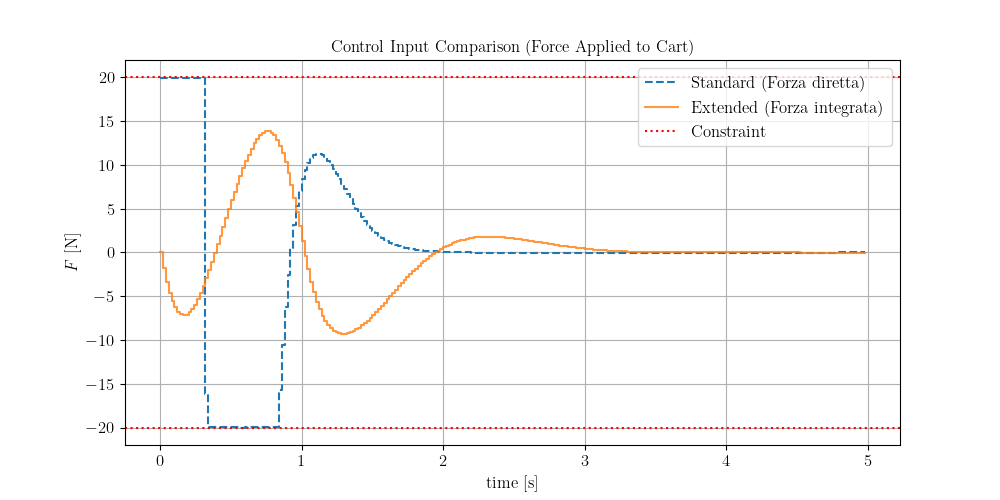

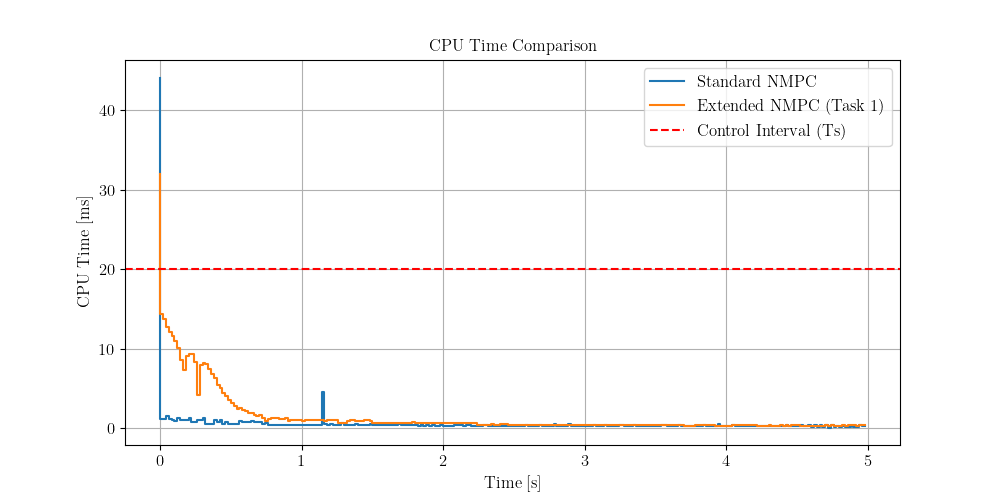

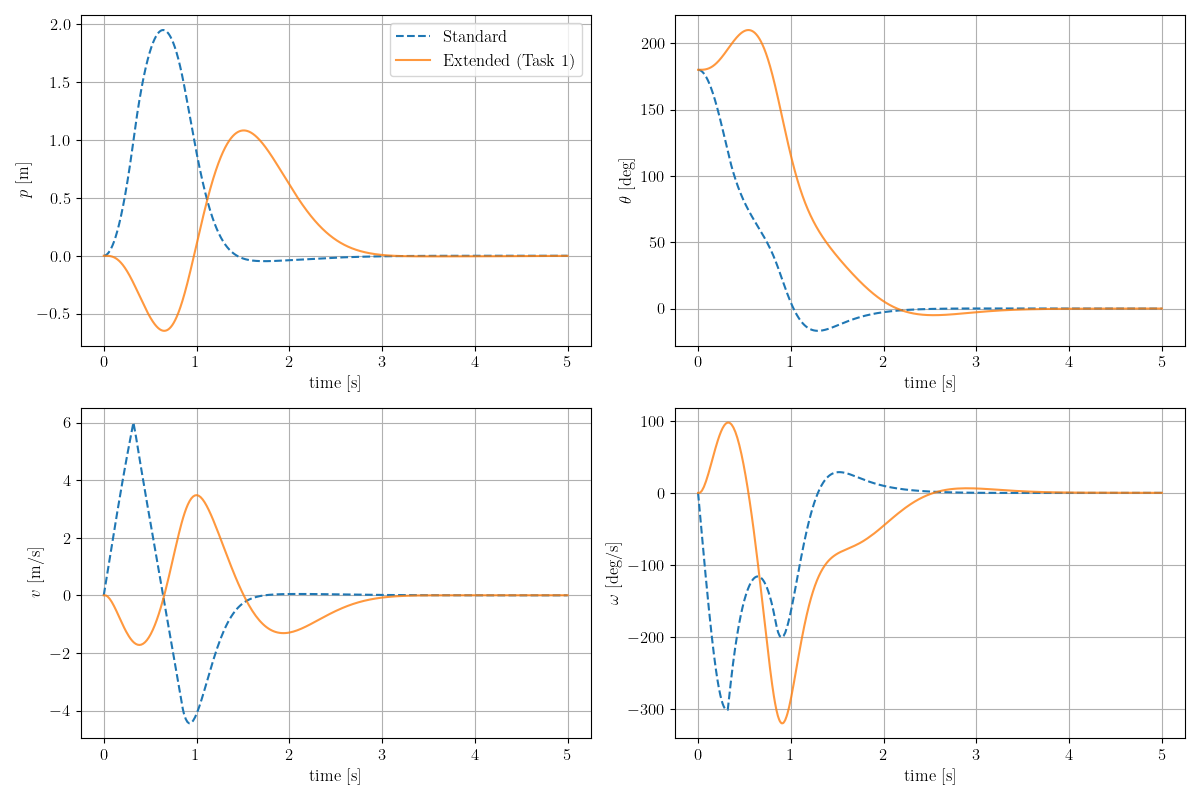

In [14]:
# --- Calcolo Medie CPU Time ---
print(f"Average CPU time (Standard): {np.mean(cpt_std)*1000:.3f} ms") # [cite: 113]
print(f"Average CPU time (Extended): {np.mean(cpt_ext)*1000:.3f} ms") # [cite: 113]

# --- Definizione assi temporali ---
time    = np.linspace(0, ts_sim * N_steps, N_steps + 1)
time_dt = np.linspace(0, Ts * (N_steps_dt - 1), N_steps_dt)

# --- Plotting ---
#import matplotlib.pyplot as plt

plt.close('all')

plot_comparison(time, time_dt, simX_std, simU_std, simX_ext, simU_ext)    

# 1. Confronto traiettorie degli stati (simX_std vs simX_ext)
# Puoi usare la tua funzione plot_results adattandola o chiamandola due volte
# plot_results(time, time_dt, simX_std, simU_std) 
# plt.gcf().suptitle('NMPC Standard Results')

# plot_results(time, time_dt, simX_ext, simU_ext)
# plt.gcf().suptitle('NMPC Extended Results (Task 1)')

# 2. Confronto CPU Time (Sovrapposti per vedere la differenza)
plt.figure(figsize=(10, 5))
plt.step(time_dt, cpt_std * 1000, label='Standard NMPC')
plt.step(time_dt, cpt_ext * 1000, label='Extended NMPC (Task 1)')
plt.axhline(y=Ts*1000, color='r', linestyle='--', label='Control Interval (Ts)')
plt.xlabel('Time [s]')
plt.ylabel('CPU Time [ms]')
plt.title('CPU Time Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
'''
print("Average total CPU time: " + str(np.mean(cpt)*1000) + " ms")

time    = np.linspace(0, ts_sim * N_steps, N_steps + 1)
time_dt = np.linspace(0, Ts * (N_steps_dt-1), N_steps_dt)

matplotlib.pyplot.close('all')
plot_results(time, time_dt, simX, simU)
plot_cpt(time_dt, cpt, Ts)
'''


'\nprint("Average total CPU time: " + str(np.mean(cpt)*1000) + " ms")\n\ntime    = np.linspace(0, ts_sim * N_steps, N_steps + 1)\ntime_dt = np.linspace(0, Ts * (N_steps_dt-1), N_steps_dt)\n\nmatplotlib.pyplot.close(\'all\')\nplot_results(time, time_dt, simX, simU)\nplot_cpt(time_dt, cpt, Ts)\n'

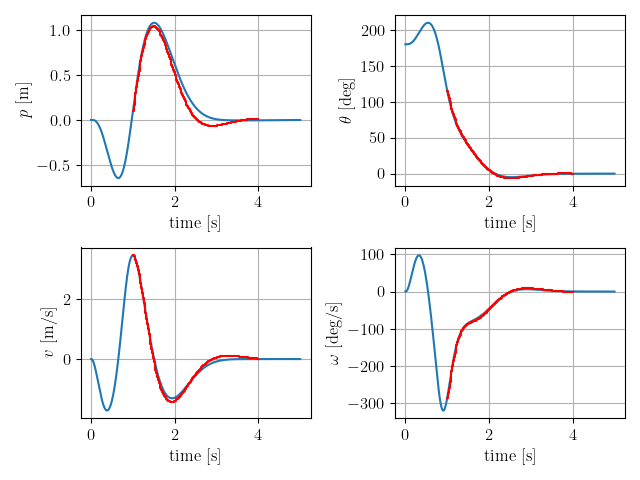

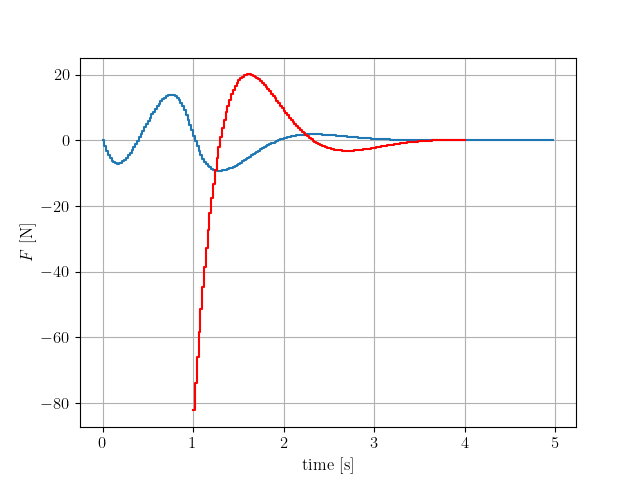

In [17]:

# 1. Trova l'indice correttamente
# Usa [0,0] per prendere il primo indice trovato ed essere sicuro di avere un intero
indices = np.argwhere(np.round(time_dt, 3) == 1)

if indices.size > 0:
    k_idx = indices[0, 0] # Estrae l'intero scalare
    
    # 2. Chiama la funzione passando l'intero k_idx
    # Nota: Assicurati che le dimensioni di x_opt/u_opt sliced siano coerenti con k_idx
    plot_pred_traj(time, time_dt, simX_ext, simU_ext, x_opt_ext[:, :, 1:], u_opt_ext[:, :, 1:], k_idx)
else:
    print("Errore: Il tempo t=5.0s non è stato trovato in time_dt. Verifica la durata della simulazione.")



In [ ]:
inverted_pendulum_animation(simX_ext[:,0], simX_ext[:, 1], ts_sim)

Video("simulation.mp4", width=640, height=480)

Generating Animation: 100%|██████████████| 101/101 [00:06<00:00, 16.31it/s]


No such comm: 8857165c1ed24a8793a5044910c81bd9
No such comm: 8857165c1ed24a8793a5044910c81bd9
No such comm: 8857165c1ed24a8793a5044910c81bd9
No such comm: 8857165c1ed24a8793a5044910c81bd9
No such comm: 8857165c1ed24a8793a5044910c81bd9
No such comm: 8857165c1ed24a8793a5044910c81bd9
No such comm: 8857165c1ed24a8793a5044910c81bd9
No such comm: 8857165c1ed24a8793a5044910c81bd9
No such comm: 8857165c1ed24a8793a5044910c81bd9
No such comm: 8857165c1ed24a8793a5044910c81bd9
No such comm: 8857165c1ed24a8793a5044910c81bd9


In [19]:
inverted_pendulum_animation(simX_std[:,0], simX_std[:, 1], ts_sim)

Video("simulation.mp4", width=640, height=480)

Generating Animation: 100%|██████████████| 101/101 [00:04<00:00, 20.34it/s]


No such comm: 441fbb82d43b4ae3adb0c9319588cecd
No such comm: 441fbb82d43b4ae3adb0c9319588cecd
No such comm: 441fbb82d43b4ae3adb0c9319588cecd
No such comm: 441fbb82d43b4ae3adb0c9319588cecd
No such comm: 441fbb82d43b4ae3adb0c9319588cecd
No such comm: 441fbb82d43b4ae3adb0c9319588cecd
No such comm: 441fbb82d43b4ae3adb0c9319588cecd
No such comm: 441fbb82d43b4ae3adb0c9319588cecd
No such comm: 441fbb82d43b4ae3adb0c9319588cecd
No such comm: 441fbb82d43b4ae3adb0c9319588cecd
No such comm: 441fbb82d43b4ae3adb0c9319588cecd
No such comm: 441fbb82d43b4ae3adb0c9319588cecd


## [TASK 2.3] Presence of model mismatch
We will now consider the case where the prediction model differs from the one used to simulate the
system dynamics, not only due to a different time step for integration, but also because of an actual
difference in their formulation.\
To achieve this, we will insert a mismatch in the parameters of the system. For example, you can
take as actual length of the pendulum $l_{true} = 0.9 m$, whereas the prediction model is written with
$l= 0.8 m$.\
Perform some tests with a mismatch commenting what happens in terms of control performances,
particularly analyzing the predicted trajectories.
Moreover, explore different tuning of the cost function and study what happens when changing the
prediction horizon length.\
$\textbf{Remark}$
In inserting the mismatch, make sure to give two different values to the field name of the AcadosModel
objects accounting for the simulation and the control models.

In [15]:
# --- 3. FUNZIONE DI CONFIGURAZIONE OCP ---
def create_ocp_solver_description_task2(model, N, T, x0):
    # create ocp object to formulate the OCP
    ocp = AcadosOcp()

    # define system dynamics model
    ocp.model = model

    # set prediction horizon
    ocp.dims.N = N
    ocp.solver_options.tf = T
    ocp.solver_options.N_horizon = N
    
    # get state, control and cost dimensions
    nx = model.x.rows()
    nu = model.u.rows()

    ny = nx + nu
    ny_e = nx

    # define cost type
    ocp.cost.cost_type = 'LINEAR_LS'
    ocp.cost.cost_type_e = 'LINEAR_LS'

    # --- COSTI (Tuning Aggressivo per Swing-up) ---
    # Q: Penalizziamo molto Theta (50) per forzare la salita
    # R: Costo input BASSISSIMO (0.01) per dare potenza
    # define cost weigth matrices
    Q_diag = [10.0, 10.0, 0.1, 0.01]
    Q = np.diag(Q_diag) 
    R_diag = [0.01]
    R_mat = np.diag(R_diag)

    ocp.cost.W = block_diag(Q, R_mat)
    ocp.cost.W_e = T/N * Q

    # define matrices characterizing the cost
 
    ocp.cost.Vx = np.vstack((np.eye(nx), np.zeros((nu, nx))))
    ocp.cost.Vu = np.vstack((np.zeros((nx, nu)), np.eye(nu)))
    ocp.cost.Vx_e = np.eye(nx)

    # initialize variables for reference
    ocp.cost.yref = np.zeros((ny,))
    ocp.cost.yref_e = np.zeros((ny_e,))

    ocp.constraints.idxbu = np.array([0])
    ocp.constraints.lbu = np.array([-20.0])
    ocp.constraints.ubu = np.array([+20.0])
    
    ocp.constraints.x0 = x0

    # --- OPZIONI SOLVER ---
    ocp.solver_options.qp_solver = 'PARTIAL_CONDENSING_HPIPM'
    ocp.solver_options.hessian_approx = 'GAUSS_NEWTON'
    ocp.solver_options.integrator_type = 'ERK'
    ocp.solver_options.nlp_solver_type = 'SQP'
    
    ocp.solver_options.nlp_solver_max_iter = 100
    ocp.solver_options.qp_solver_iter_max = 50
    ocp.solver_options.qp_solver_warm_start = 0
    #ocp.solver_options.sim_method_num_steps = 4

    return ocp

In [ ]:
import shutil
import os
if os.path.exists('c_generated_code'):
    shutil.rmtree('c_generated_code')

In [28]:
import shutil
# --- 1. PULIZIA E SETUP INIZIALE ---
# Rimuove la cartella del codice generato per obbligare Acados a ricompilare
if os.path.exists('c_generated_code'):
    shutil.rmtree('c_generated_code')

In [29]:
# define simulation fundamental time step [s]
ts_sim = 0.001

# [SIMULATOR - REAL SYSTEM]
# model used to simulate the system [l=0.9]
model_sim = get_inverted_pendulum_model(l=0.9)
model_sim.name = "pendulum_real_mismatch"

# initial condition 
x0 = np.array([0, np.pi, 0, 0])

# [CONTROLLER]
# setup controller parameters using the nominal model
# - system model
model_mpc = get_inverted_pendulum_model(l=0.8)
model_mpc.name = "pendulum_nominal_v2"

# - controller sample time [s]
Ts = 0.02
# - number of shooting time intervals
N = 100
# - prediction horizon length [s]
T = N * Ts

Tf = 5.0

nx, nu = model_mpc.x.rows(), model_mpc.u.rows()

N_steps, N_steps_dt, n_update = compute_num_steps(ts_sim, Ts, Tf)
total_steps_ref = N_steps_dt + N + 1
y_ref1 = np.zeros((total_steps_ref, nx + nu))

shifting    = True 
ref_preview = False



Code generation and integrator

In [ ]:
# --- 4. GENERAZIONE SOLVER E INTEGRATORE ---
clear_previous_simulation()
# setup simulation of system dynamics [REAL SYSTEM]
sim = AcadosSim()
sim.model = model_sim
sim.solver_options.T = ts_sim 
sim.solver_options.integrator_type = 'ERK'
#sim.solver_options.num_stages = 4 
#sim.solver_options.num_steps = 10
#acados_integrator = AcadosSimSolver(sim, json_file="acados_sim_task2.json")
acados_integrator = AcadosSimSolver(sim, verbose=False)

# 4.1 Crea Descrizione OCP e Solver MPC (usando il modello nominale)
ocp_desc = create_ocp_solver_description_task2(model_mpc, N, T, x0)
#acados_ocp_solver = AcadosOcpSolver(ocp_desc, json_file="acados_ocp_task2.json")
acados_ocp_solver = AcadosOcpSolver(ocp_desc, verbose=False)

# Recupero dimensioni corrette
nx_sim = model_sim.x.rows() # 4 (p, theta, v, omega)
nu_sim = model_sim.u.rows() # 1 (F)
nx_mpc = model_mpc.x.rows()     # 4 (p, theta, v, omega)
nu_mpc = model_mpc.u.rows()     # 1 (F)

# initialize solver
for stage in range(N):
    acados_ocp_solver.set(stage, "x", x0)
    acados_ocp_solver.set(stage, "u", np.zeros((nu_mpc,)))
acados_ocp_solver.set(N, "x", x0)

# define iteration counter for the discrete-time part of the control loop
k = 0

# create variables to store state and control trajectories 
simX = np.zeros((N_steps + 1, nx_sim))
simU = np.zeros((N_steps_dt, nu_sim))
predX = np.zeros((N_steps_dt, N+1, nx_mpc))
predU = np.zeros((N_steps_dt, N, nu_mpc))

# set intial state
simX[0, :] = x0

# create variables to store, at each iteration, previous optimal solution (extended states)
x_opt = np.zeros((N+1, nx_mpc, N_steps_dt + 1))
x_opt[:, :, 0] = np.repeat(x0.reshape(1,-1), N+1, axis=0)
u_opt = np.zeros((N, nu_mpc, N_steps_dt + 1))
# variable to store total CPU time
cpt = np.zeros((N_steps_dt,))

for i in tqdm(range(N_steps), desc="Simulation Task 2.3",ascii=False, ncols=75, colour='green'):

    # A. Aggiornamento Controllo
    if (i % n_update == 0):
        
        # 1. Imposta il feedback
        #acados_ocp_solver.set(0, "x", simX[i, :])
        
        # 2. Aggiorna riferimenti
        # Usiamo y_ref1 che ora ha dimensione 5 (corretta per questo solver)
        for j in range(N):
            acados_ocp_solver.set(j, "yref", y_ref1[k + (j if ref_preview else 0), :])
            
        # Riferimento terminale (Solo stati -> dim 4)
        # Assicurati di prendere solo i primi nx_orig elementi
        acados_ocp_solver.set(N, "yref", y_ref1[k + (N if ref_preview else 0), :nx_mpc])
        # if performing shifting, explicitly initialize solver
        # (otherwise, it will be automatically intialized with the previous solution)
        if shifting:
            for stage in range(N):
                acados_ocp_solver.set(stage, "x", x_opt[stage+1, :, k])
                acados_ocp_solver.set(stage, "u", u_opt[min([stage+1,N-1]), :, k])
    
            acados_ocp_solver.set(N, "x", x_opt[N, :, k])
        # update the control 

        simU[k, :] = acados_ocp_solver.solve_for_x0(simX[i, :], 
                                                    fail_on_nonzero_status=False,
                                                    print_stats_on_failure=False)

        # store CPU time required for solving the problem
        cpt[k] = acados_ocp_solver.get_stats('time_tot')

        
        # store optimal solution
        for stage in range(N):
            x_opt[stage, :, k+1] = acados_ocp_solver.get(stage, "x")
            u_opt[stage, :, k+1] = acados_ocp_solver.get(stage, "u")
            
        x_opt[N, :, k+1] = acados_ocp_solver.get(N, "x")
        
        
        # update discrete-time iteration counter
        k += 1
        

    # simulate system
    simX[i + 1, :] = acados_integrator.simulate(simX[i,:], simU[k-1, :])

In [ ]:
print("Average total CPU time: " + str(np.mean(cpt)*1000) + " ms")
'''

time    = np.linspace(0, ts_sim * N_steps, N_steps + 1)
time_dt = np.linspace(0, Ts * (N_steps_dt-1), N_steps_dt)

matplotlib.pyplot.close('all')
plot_results(time, time_dt, simX, simU)
plot_cpt(time_dt, cpt, Ts)
'''


VISUALIZZAZIONE

In [ ]:
# --- 6. VISUALIZZAZIONE ---
print("Average total CPU time: " + str(np.mean(cpt)*1000) + " ms")
# Creiamo i vettori tempo corretti
t_sim = np.linspace(0, Tf, N_steps+1) 
t_u = np.linspace(0, Tf, N_steps)  
indices = np.argwhere(np.round(time_dt, 3) == 1) 
if indices.size > 0:
    k_idx = indices[0, 0] # Estrae l'intero scalare
    
    # 2. Chiama la funzione passando l'intero k_idx
    # Nota: Assicurati che le dimensioni di x_opt/u_opt sliced siano coerenti con k_idx
    plot_pred_traj(time, time_dt, simX, simU, x_opt[:, :, 1:], u_opt[:, :, 1:], k_idx)
else:
    print("Errore: Il tempo t=5.0s non è stato trovato in time_dt. Verifica la durata della simulazione.")  

# Scegli un istante k interessante (es. 1.5 secondi)
#k_to_plot = int(1.5 / Ts) 
#if k_to_plot >= N_steps: k_to_plot = N_steps - 1

#print(f"Analisi predizione all'istante t = {t_sim[k_to_plot]:.2f}s")

# Plot finale con predizioni
#plot_pred_traj(t_sim, t_u, simX, simU, x_opt, u_opt, k_to_plot)
#plot_pred_traj(t_sim, t_u, simX, simU, x_opt[:, :, 1:], u_opt[:, :, 1:])




In [ ]:

# downsample for animation
# Calcola il fattore di sottocampionamento (es. 0.02 / 0.001 = 20)
ratio = int(Ts / ts_sim)

# # Prendi solo un campione ogni 'ratio' (es. ogni 20)
# simX_resampled = simX[::ratio, :]

# # Ora passiamo simX_resampled e il tempo Ts coerente con questi dati
# inverted_pendulum_animation(simX_resampled[:, 0], simX_resampled[:, 1], Ts)

# Genera il video
Video("simulation.mp4", width=640, height=480)

inverted_pendulum_animation(simX[:,0], simX[:, 1], ts_sim)

Video("simulation.mp4", width=640, height=480)


## [task 3] Comparing NMPC with linear MPC
Even though acados is a software tool for Nonlinear Model Predictive Control, it can be used also for
linear Model Predictive Control. Indeed, you can always specify in your problem formulation a linear
dynamics instead of a nonlinear one. In such case, with the usual definition of the cost function
and specifying linear constraints (like bounds), the Nonlinear Programming (NLP) problem which is
obtained by Direct Multiple Shooting is actually a Quadratic Programming (QP) problem. Then,
this can be solved in a single iteration of the SQP algorithm.4
By leveraging acados, design and implement a linear MPC controller using the linearized model (2),
test it in simulation (using as simulation model still the nonlinear one) and then compare it against
a NMPC controller which instead exploits the nonlinear model of the system. The control task to
be considered is not the swing-up maneuver, but the tracking of a piecewise constant reference for
the cart position, defined as

Linearised system around the upright position


In [23]:
def get_linearized_model(M=1, m=0.1, l=0.8, g=9.81)-> AcadosModel:
    #set model name
    model_name = 'linear_pendulum'

    #the physical parameters of the system are passed as parameters
    # g - gravity acceleration [m/s**2]
    # M - cart mass [kg]
    # m - pendulum mass [kg]
    # l - pendulum length [m]
    
    A = np.array([
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, m*g/M, 0, 0],
        [0, (M+m)*g/(M*l), 0, 0]
    ])
    
    B = np.array([
        [0],
        [0],
        [1/M],
        [1/(M*l)]
    ])

    # setup states and controls symbolic variables
    p = ca.SX.sym('p', 1, 1)
    theta = ca.SX.sym('theta', 1, 1)
    v = ca.SX.sym('v', 1, 1)
    omega = ca.SX.sym('omega', 1, 1)
    x = ca.vertcat(p, theta, v, omega)
    
    u = ca.SX.sym('F', 1, 1)

    xdot = ca.SX.sym('xdot', 4)

    # Ax + Bu
    f_expl = ca.mtimes(A, x) + ca.mtimes(B, u)
    f_impl = xdot - f_expl

    model = AcadosModel()
    model.f_impl_expr = f_impl
    model.f_expl_expr = f_expl
    model.x = x
    model.xdot = xdot
    model.u = u
    model.name = model_name
    return model

In [24]:
def create_ocp_solver_description_task3(model, N, T, x0, is_linear_mpc=False):
    # create ocp object to formulate the OCP
    ocp = AcadosOcp()

    # define system dynamics model
    ocp.model = model

    # set prediction horizon
    ocp.dims.N = N
    ocp.solver_options.tf = T
    ocp.solver_options.N_horizon = N
    
    nx = model.x.rows()
    nu = model.u.rows()
    ny = nx + nu

    # Cost type
    ocp.cost.cost_type = 'LINEAR_LS'
    ocp.cost.cost_type_e = 'LINEAR_LS'

    # --- TUNING PER TRACKING (Task 3) ---
    # Obiettivo: Seguire p_ref e tenere theta = 0
    # Q: [p, theta, v, omega]
    # define cost weigth matrices
    Q_diag = [500.0, 500.0, 1.0, 1.0] # Aumento peso su p per tracking preciso
    # Q_diag = [10.0, 10.0, 0.1, 0.01]
    R_diag = [0.1] # Penalità input moderata
    
    ocp.cost.W = block_diag(np.diag(Q_diag), np.diag(R_diag))
    ocp.cost.W_e = np.diag(Q_diag) * (T / N)

    # define matrices characterizing the cost
    ocp.cost.Vx = np.vstack((np.eye(nx), np.zeros((nu, nx))))
    ocp.cost.Vu = np.vstack((np.zeros((nx, nu)), np.eye(nu)))
    ocp.cost.Vx_e = np.eye(nx)

    # initialize variables for reference
    ocp.cost.yref = np.zeros((ny,))
    ocp.cost.yref_e = np.zeros((nx,))

    # Constraints
    ocp.constraints.idxbu = np.array([0])
    ocp.constraints.lbu = np.array([-20.0])
    ocp.constraints.ubu = np.array([+20.0])
    ocp.constraints.x0 = x0
    # --- SOLVER OPTIONS ---
    ocp.solver_options.qp_solver = 'PARTIAL_CONDENSING_HPIPM'
    ocp.solver_options.hessian_approx = 'GAUSS_NEWTON'
    ocp.solver_options.integrator_type = 'ERK'
    
    if is_linear_mpc:
        # PER LINEAR MPC: 1 sola iterazione SQP basta (il problema è QP) [cite: 147]
        ocp.solver_options.nlp_solver_type = 'SQP_RTI'
        #ocp.solver_options.nlp_solver_max_iter = 1
    else:
        # PER NMPC: Più iterazioni o RTI
        ocp.solver_options.nlp_solver_type = 'SQP_RTI' # o SQP con max_iter > 1
        
    return ocp

In [25]:
import numpy as np

def get_reference_trajectory(t0, t_final, ts_sim, N, Ts):
    """
    Genera la traiettoria di riferimento p_ref(t) vettorizzata.
    Restituisce il riferimento esteso (per coprire l'orizzonte futuro) e il tempo di simulazione.
    
    Args:
        t0: tempo iniziale
        t_final: tempo finale simulazione
        ts_sim: passo integrazione simulazione
        N: orizzonte predizione (step controllore)
        Ts: tempo campionamento controllore
    """
    # 1. Creazione asse temporale simulazione
    # Usiamo un piccolo epsilon per includere t_final in sicurezza
    t_eval = np.arange(t0, t_final + ts_sim/100, ts_sim)
    
    # 2. Estensione temporale per l'orizzonte di predizione
    # Calcoliamo la durata dell'orizzonte e aggiungiamo un margine
    T = N * Ts
    t_horizon_end = t_eval[-1] + T + 1.0 # +1s buffer
    t_extended = np.arange(t_eval[-1] + ts_sim, t_horizon_end, ts_sim)
    
    # Uniamo i tempi: simulazione + futuro
    t_full = np.concatenate((t_eval, t_extended))
    
    # 3. Calcolo vettorizzato di p_ref (Eq. [cite_start]6 del testo) [cite: 150]
    # Definiamo le condizioni logiche basate sul tempo
    y_ref = np.zeros((np.size(t_full), 5)) # [p, theta, v, omega, u]

    for i, t in enumerate(t_full):
        val = 0.0
        if 2.5 <= t < 5.0:
            val = 1.0
        elif 5.0 <= t < 7.5:
            val = -1.0
        # Imposta p_ref (indice 0)
        y_ref[i, 0] = val
    
    return y_ref, t_eval

In [ ]:
# Nomi variabili esatti
t_final = 10.0      # Durata simulazione [s]
ts_sim  = 0.001     # Passo integrazione simulatore [s]
Ts      = 0.05      # Passo campionamento controllore [s] (50ms)
N       = 40        # Orizzonte di predizione (numero di step)

# Calcolo parametri derivati
T = N * Ts                              # Orizzonte temporale in secondi
N_sim_steps = int(t_final / ts_sim)     # Totale passi simulazione
steps_per_ctrl = int(round(Ts / ts_sim)) # Rapporto passi (Simulatore / Controllore)

# Condizione Iniziale: [p, theta, v, omega]
x0 = np.array([0.0, 0.0, 0.0, 0.0])

# Generazione Riferimento
y_ref_traj, t_eval = get_reference_trajectory(0, t_final, ts_sim, N, Ts)

# =============================================================================
# SETUP SIMULATORE (Pianta Reale - Sempre Non Lineare)
# =============================================================================
sim_model = get_inverted_pendulum_model()
sim = AcadosSim()
sim.model = sim_model
sim.solver_options.T = ts_sim
acados_integrator = AcadosSimSolver(sim, verbose=False)

# =============================================================================
# SETUP CONTROLLORI (Linear vs NonLinear)
# =============================================================================

# 1. LINEAR MPC
linear_model = get_linearized_model()
# is_linear_mpc=True -> SQP iter = 1
linear_ocp = create_ocp_solver_description_task3(linear_model, N, T, x0, is_linear_mpc=True)
solver_lin = AcadosOcpSolver(linear_ocp, json_file='linear_ocp.json', verbose=False)

# 2. NON-LINEAR MPC
nonlinear_model = get_inverted_pendulum_model()
# is_linear_mpc=False -> SQP completa / RTI
nonlinear_ocp = create_ocp_solver_description_task3(nonlinear_model, N, T, x0, is_linear_mpc=False)
solver_nl = AcadosOcpSolver(nonlinear_ocp, json_file='nonlinear_ocp.json', verbose=False)

# Dizionario per salvare i risultati di entrambe le simulazioni
results = {}

# Lista delle configurazioni da testare
sim_configs = [
    ('Linear', solver_lin), 
    ('NonLinear', solver_nl)
]

# =============================================================================
# LOOP DI SIMULAZIONE (Itera su entrambi i controllori)
# =============================================================================

for name, solver in sim_configs:
    print(f"\n--- Avvio simulazione: {name} MPC ---")
    
    # Inizializzazione storici per questa run
    x_history = np.zeros((N_sim_steps + 1, 4))
    u_history = np.zeros((N_sim_steps, 1))
    
    # Stato iniziale
    x_current = x0.copy()
    x_history[0, :] = x_current
    u_current = np.array([0.0])
    
    # Loop Temporale
    for i in range(N_sim_steps):
        
        # A. CONTROLLO (Ogni Ts)
        if i % steps_per_ctrl == 0:
            ref_idx = i
            
            # Imposta riferimento su orizzonte
            for k in range(N):
                future_idx = ref_idx + k * steps_per_ctrl
                yref = y_ref_traj[future_idx, :]
                solver.set(k, "yref", yref)
            
            # Riferimento terminale
            term_idx = ref_idx + N * steps_per_ctrl
            yref_e = y_ref_traj[term_idx, :4]
            solver.set(N, "yref", yref_e)
            
            # Feedback stato
            solver.set(0, "lbx", x_current)
            solver.set(0, "ubx", x_current)
            
            # Risolvi
            status = solver.solve()
            if status != 0:
                print(f"Warning {name}: solver status {status} at step {i}")
            
            u_current = solver.get(0, "u")
            
        # B. SIMULAZIONE (Ogni ts_sim)
        acados_integrator.set("x", x_current)
        acados_integrator.set("u", u_current)
        
        if acados_integrator.solve() != 0:
            print(f"Integrator error at step {i}")
            
        x_current = acados_integrator.get("x")
        
        # C. LOG
        x_history[i+1, :] = x_current
        u_history[i, :] = u_current

    # Salva i risultati nel dizionario
    results[name] = {'x': x_history, 'u': u_history}

# =============================================================================
# PLOT COMPARATIVO
# =============================================================================
t_span = t_eval[:N_sim_steps+1] # Tempo per x
t_span_u = t_eval[:N_sim_steps] # Tempo per u

x_lin = results['Linear']['x']
u_lin = results['Linear']['u']
x_nl  = results['NonLinear']['x']
u_nl  = results['NonLinear']['u']

# Ricostruzione riferimento p per il plot
# (Prendiamo la colonna 0 della traiettoria generata)
ref_p = y_ref_traj[:len(t_span), 0]

plt.figure(figsize=(12, 8))

# 1. Posizione
plt.subplot(2, 2, 1)
plt.plot(t_span, x_lin[:, 0], label='Linear MPC', linewidth=1.5)
plt.plot(t_span, x_nl[:, 0], '--', label='NMPC', linewidth=1.5)
plt.plot(t_span, ref_p, 'k:', label='Ref', linewidth=1)
plt.ylabel('Posizione p [m]')
plt.title('Tracking Posizione')
plt.legend()
plt.grid(True)

# 2. Angolo
plt.subplot(2, 2, 2)
plt.plot(t_span, x_lin[:, 1], label='Linear MPC')
plt.plot(t_span, x_nl[:, 1], '--', label='NMPC')
plt.ylabel('Angolo theta [rad]')
plt.title('Stabilizzazione Angolo')
plt.grid(True)

# 3. Velocità Carrello
plt.subplot(2, 2, 3)
plt.plot(t_span, x_lin[:, 2], label='Linear MPC')
plt.plot(t_span, x_nl[:, 2], '--', label='NMPC')
plt.ylabel('Velocità v [m/s]')
plt.xlabel('Tempo [s]')
plt.grid(True)

# 4. Input (Forza)
plt.subplot(2, 2, 4)
plt.step(t_span_u, u_lin, label='Linear MPC', where='post')
plt.step(t_span_u, u_nl, '--', label='NMPC', where='post')
plt.ylabel('Forza F [N]')
plt.xlabel('Tempo [s]')
plt.title('Input di Controllo')
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
# print the total CPU time for both controllers
time_lin = np.mean([solver_lin.get_stats('time_tot') for _ in range(N_sim_steps)])
time_nl  = np.mean([solver_nl.get_stats('time_tot') for _ in range(N_sim_steps)])
print(f"Average CPU time Linear MPC: {time_lin*1000:.2f} ms")
print(f"Average CPU time NMPC: {time_nl*1000:.2f} ms")
